### QAOA for Spin Heisenberg lattice
Exchange packages Qiskit to QLM to Cirq

\begin{equation*}
H = \sum_{\langle i,j\rangle} [X_i X_j + Y_i Y_j + Z_i Z_j ]
\end{equation*}

The above equation is for the Heisenberg spin lattice in which the interactions are only between neighboring qubits, or by other words between neighbor spins.

Finding the ground state of such model has important applications, since this leads to decide some properties/characteristics of different lattices. Also, it is used in studying quantum phase transitions, superconductivity, and localization in disordered systems.

### Outline
<ol>
    <li>Building the hamiltonian</li>
    <li>Energy calculation using Qiskit</li>
    <li>Energy calculation using QLM</li>
    <li>Energy calculation using Cirq</li>
    <li>Conclusion</li>
    <li>References</li>
</ol>

### Building the hamiltonian
<hr>

In [1]:
import networkx as nx

Build the lattice as a rectangular shape.

In [2]:
graph = nx.generators.lattice.grid_2d_graph(3,2)
graph = nx.relabel.convert_node_labels_to_integers(graph)

The following lattice has direct interactions(edges) between the spins. In fact we will use the missing edges to represent non direct interactions between the spin, which of course have smaller interactions.

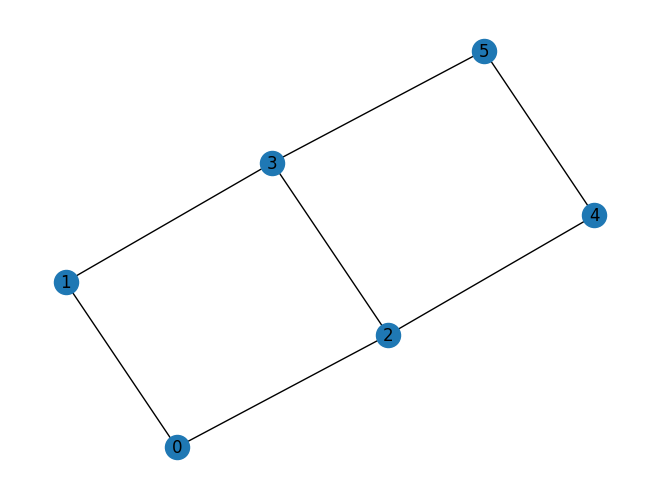

In [7]:
nx.draw(graph, labels={0:0, 1:1, 2:2, 3:3, 4:4, 5:5})

If we want to add non-neighbor interactions then the equation becomes the following.
\begin{equation*}
H = J_{1}\sum_{\langle i,j\rangle} [X_i X_j + Y_i Y_j + Z_i Z_j ] + J_{2}\sum_{\langle h,k\rangle} [X_h X_k + Y_h Y_k + Z_h Z_k ]
\end{equation*}
Where <h,k> represents the missing edges/secondary interactions and both interaction types have different $J$ representing the interaction term.

We will assume that the interaction $J$ in each direction X, Y and Z is the same.

In [8]:
edges = graph.edges()
print(edges)

[(0, 2), (0, 1), (1, 3), (2, 4), (2, 3), (3, 5), (4, 5)]


In [9]:
non_edges = nx.non_edges(graph)
print(list(non_edges))

[(0, 3), (0, 4), (0, 5), (1, 2), (1, 4), (1, 5), (2, 5), (3, 4)]


The following function will be used with other code/functions to build the hamiltonian.

In [10]:
def replace_char(string, index, new_char):
    return string[:index] + new_char + string[index+1:]

We now build the hamiltonian.

In [11]:
from qiskit.opflow import X, Y, Z, I
from qiskit.quantum_info.operators import Operator, Pauli

C:\Users\husse\AppData\Local\Temp\ipykernel_3220\2149201498.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed in Qiskit 1.0. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Y, Z, I


In [12]:
hamiltonian = []
total_edges = [list(edges), nx.non_edges(graph)]

for i in range(2):
    for edge in total_edges[i]:
        for p in ['X', 'Y', 'Z']:
            h2 = 'IIIIII'
            h2 = replace_char(h2, edge[0], p)
            h2 = replace_char(h2, edge[1], p)
            hamiltonian.append(h2)
print(hamiltonian)

['XIXIII', 'YIYIII', 'ZIZIII', 'XXIIII', 'YYIIII', 'ZZIIII', 'IXIXII', 'IYIYII', 'IZIZII', 'IIXIXI', 'IIYIYI', 'IIZIZI', 'IIXXII', 'IIYYII', 'IIZZII', 'IIIXIX', 'IIIYIY', 'IIIZIZ', 'IIIIXX', 'IIIIYY', 'IIIIZZ', 'XIIXII', 'YIIYII', 'ZIIZII', 'XIIIXI', 'YIIIYI', 'ZIIIZI', 'XIIIIX', 'YIIIIY', 'ZIIIIZ', 'IXXIII', 'IYYIII', 'IZZIII', 'IXIIXI', 'IYIIYI', 'IZIIZI', 'IXIIIX', 'IYIIIY', 'IZIIIZ', 'IIXIIX', 'IIYIIY', 'IIZIIZ', 'IIIXXI', 'IIIYYI', 'IIIZZI']


We also define the number of repetition n, also the number of qubits, then $J_{1}$ and $J_{2}$, the terms representing the interactions strength for neighbor and non-neighbor spins/qubits.

In [13]:
n = 2
num_qubits = 6
J1 = -1.5
J2 = -0.257

We now define the parameters, we need one parameter for each $H_c$ layer and one parameter for each $H_m$ layer.

QAOA is made of successive repetition of these 2 layers n-times. So we need $2*n$ parameters.

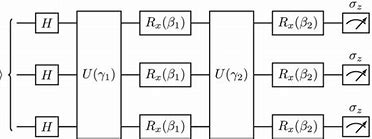

It is worth mentioning thet the $H_m$ layer is made of $R_{x}$ gates.

In [14]:
from qiskit.circuit import Parameter
from qiskit import *
params = []

for i in range(0, 2*n, 2):
    params.append([Parameter('a'+str(i)), Parameter('a'+str(i+1))])

Now we implement the functions to build the operator/hamiltonian in qiskit and build the circuit layers.

To implement the exponential gate we use qiskit gates:

<ul>
    <li>RXXGate()</li>
    <li>RYYGate()</li>
    <li>RZZGate()</li>
</ul>

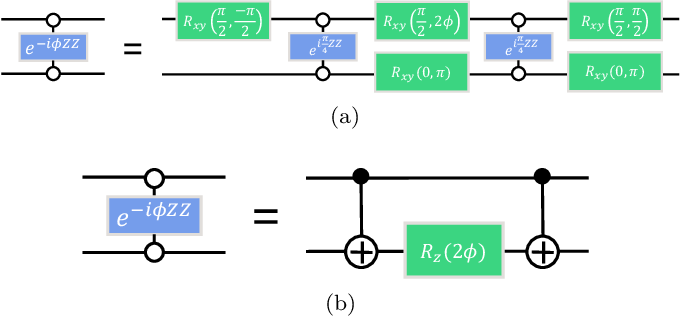

For example if have the following term 'IXXI' in the hamiltonian, we use RXXGate(param, [1, 2]) on qubits 1 and 2 and not 0 and 4.

In [15]:
from qiskit.circuit.library import *

def circuit(hamiltonian, param, num_qubits):
    qc = QuantumCircuit(num_qubits, num_qubits)
    i = 0
    for h in hamiltonian:
        i += 1
        for p in ['X', 'Y', 'Z']:
            if p in h:

                index1 = h.find(p)
                index2 = h.rfind(p)

                if i < 22:
                    prmtr = J1
                if i >= 22:
                    prmtr = J2
                if p == 'X':
                    qc.append(RXXGate(prmtr*param[0]), [index1, index2])
                elif p == 'Y':
                    qc.append(RYYGate(prmtr*param[0]), [index1, index2])
                elif p == 'Z':
                    qc.append(RZZGate(prmtr*param[0]), [index1, index2])
    qc = qc.decompose()
    for i in range(num_qubits):
        qc.rx(param[1], i)
    return qc

qc = QuantumCircuit(num_qubits,num_qubits)
for i in range(num_qubits):
        qc.h(i)

for i in range(n):
    qc = qc.compose(circuit(hamiltonian, params[i], num_qubits))

The circuit is big, uncommenting the next cell draws it if needed.

In [16]:
#qc.draw('mpl')

Now we build the hamiltonian according to the previous seen equation to be ready for use with qiskit.

In [17]:
def ham(hamiltonian):
    h_heisenberg = J1*Operator(Pauli('IIIIII'))
    for h in hamiltonian:
        for p in ['X', 'Y', 'Z']:
            if p in h:
                index1 = h.find(p)
                index2 = h.rfind(p)

                if (index1, index2) in edges:
                    h_heisenberg += J1*Operator(Pauli(h))
                else:
                    h_heisenberg += J2*Operator(Pauli(h))
    h_heisenberg = h_heisenberg - J1*Operator(Pauli('IIIIII'))
    return h_heisenberg

h_heisenberg = ham(hamiltonian)
#h_heisenberg

After building the hamiltonian and the circuit successfully, we now import the ansatz and start the estimation of the ground state energy.

In [18]:
from qiskit_algorithms.optimizers import SLSQP, ADAM
from qiskit import *

optimizer = SLSQP(maxiter=50)

Function to save the output at each iteration.

In [19]:
counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

Now we run and build VQE.

In [20]:
from qiskit.primitives import Estimator

estimator = Estimator()

In [21]:
from qiskit_algorithms import VQE

vqe = VQE(estimator, qc, optimizer, callback=store_intermediate_result)

In [22]:
result = vqe.compute_minimum_eigenvalue(h_heisenberg)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 5,
    'eigenvalue': -12.555999999999944,
    'optimal_circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001C22D6AC700>,
    'optimal_parameters': {   Parameter(a0): 5.51602017172536,
                              Parameter(a2): 3.2686948406717313,
                              Parameter(a1): 4.820975051325506,
                              Parameter(a3): -2.135790300144646},
    'optimal_point': array([ 5.51602017,  4.82097505,  3.26869484, -2.1357903 ]),
    'optimal_value': -12.555999999999944,
    'optimizer_evals': None,
    'optimizer_result': <qiskit_algorithms.optimizers.optimizer.OptimizerResult object at 0x000001C22BE6EAA0>,
    'optimizer_time': 7.04787802696228}


In [23]:
counts

[1, 2, 3, 4, 5]

In [24]:
values

[-12.555999999999944,
 -12.555999999999944,
 -12.555999999999923,
 -12.55599999999997,
 -12.555999999999955]

If we plot the ground state energy we get approximately a straight line and that is normal because QAOA was able to predict directly from first 5 iterations the ground state energy.

This shows the power of the QAOA ansatz for the heisenberg problem.

Now we will use VQE with a known ansatz, TWOLocal, and not a QAOA ansatz.

In [25]:
from qiskit.circuit.library import TwoLocal

num_qubits = 6
ansatz = TwoLocal(num_qubits, "ry", "cz")

C:\Users\husse\anaconda3\envs\openvqeQAOA\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


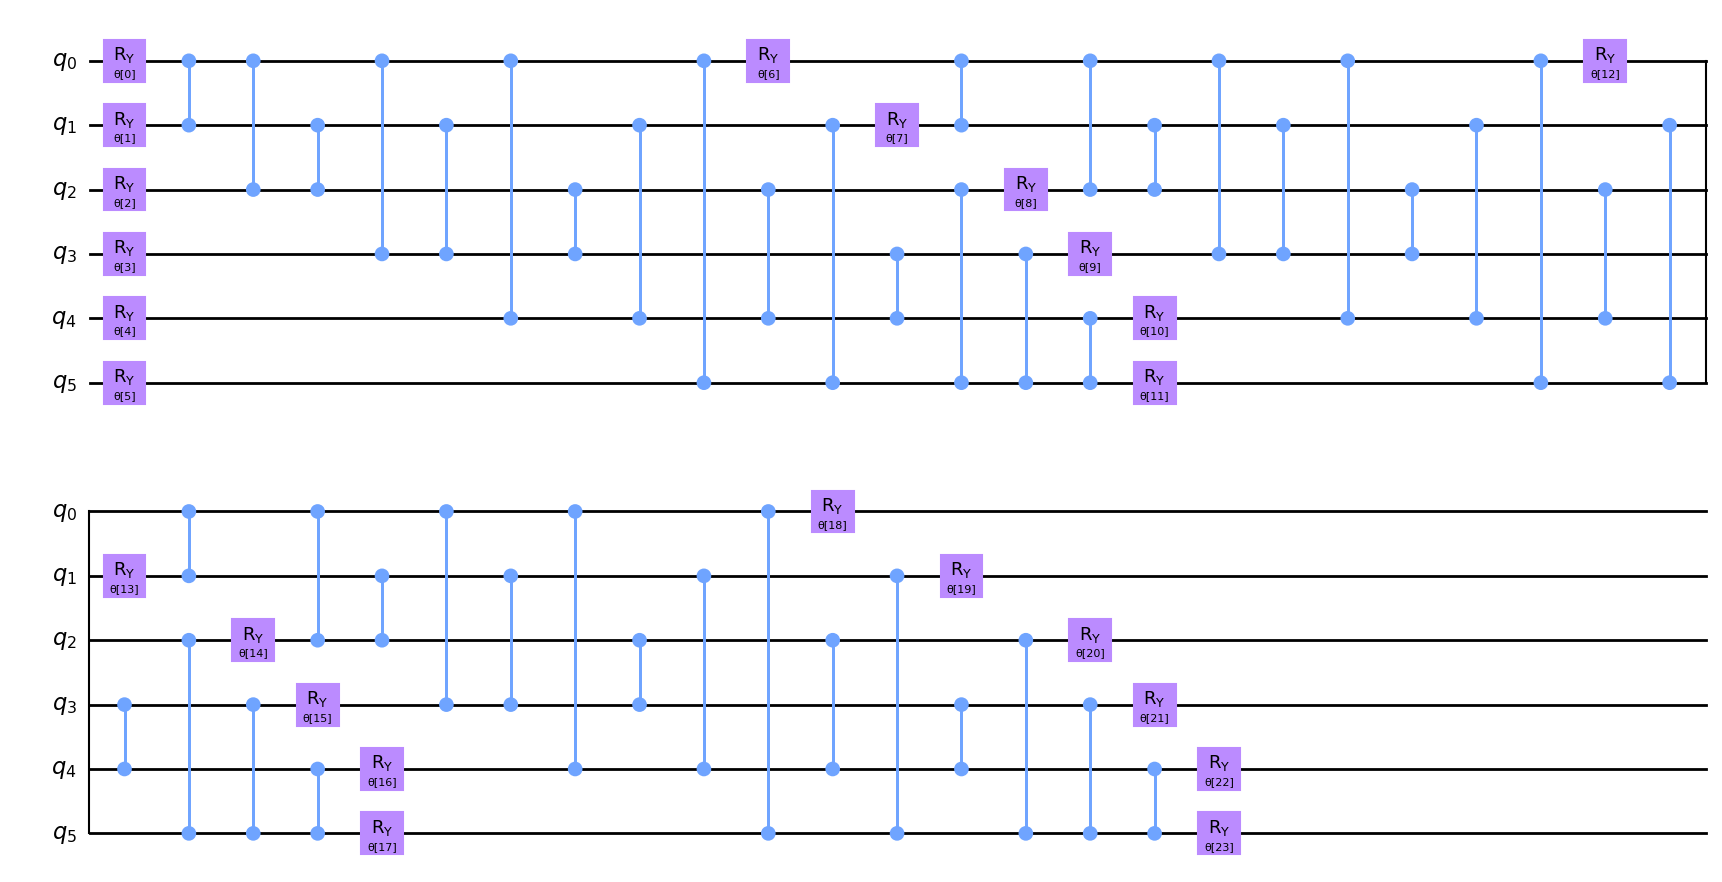

In [26]:
ansatz.decompose().draw('mpl')

We now calculate the energy using TWOLocal ansatz and we see that we needed 100's of iterations instead of only 5 to reach a value near the real ground energy state.

In [27]:
counts = []
values = []

vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)

result = vqe.compute_minimum_eigenvalue(h_heisenberg)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 1017,
    'eigenvalue': -12.555986670055344,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x000001C22FAA21A0>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 1.5779393218225612,
                              ParameterVectorElement(θ[1]): 4.665120552646317,
                              ParameterVectorElement(θ[2]): 1.556931814887582,
                              ParameterVectorElement(θ[3]): -1.5760071931173036,
                              ParameterVectorElement(θ[4]): 1.6453328159743223,
                              ParameterVectorElement(θ[5]): 4.702742391364418,
                              ParameterVectorElement(θ[6]): -6.925149652295762,
                              ParameterVectorElement(θ[7]): 3.7786999116395803,
                              ParameterVectorElement(θ[8]): 2.739894990088686,
                              ParameterVectorElement(θ[9]): 4.0417929

Text(0.5, 1.0, 'Convergence with no noise')

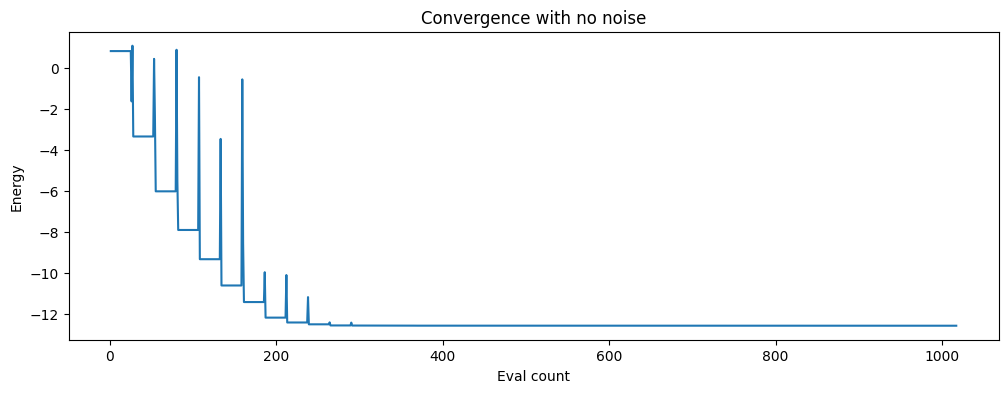

In [28]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")

In this notebook we use 3 quantum programming languages, Qiskit, QLM and Cirq to calculate the ground state energy of $H$ hamiltonian of Heisenberg spin lattice.

We also make use of the myQLM library to exchange between the programming languages packages.

We start with qiskit then qlm and finally cirq.

<table ><tr><th >Algorithm <th><th> Parameters <th><th> Iterations till convergence <th>Depth</th><tr><tr>
<tr><td> VQE TWOLocal <td><td> 24 <td><td> 300 <td>53<tr> <tr>
<tr><td> QAOA <td><td> 4 <td><td> 5 <td>263<tr><table>

### Energy calculation using QLM
<hr>

First we need to change the circuit from Qiskit to QLM

In [29]:
from qat.lang import *
from qat import *
from qat.interop.qiskit import qiskit_to_qlm

qlm_circuit = qiskit_to_qlm(qc)

In [30]:
#qlm_circuit().display()

After successfully changing the circuit, we can now find the parameters present in it.

In [31]:
qlm_circuit.get_variables()

['a0', 'a1', 'a2', 'a3']

Now we build the hamiltonion for this lattice manually the same as the one in Qiskit, since myQLM library supports changing circuit between packages and not changing hamiltonian.

In [32]:
from qat.core import Observable, Term

my_observable = Observable(6, # A 6 qubits observable
                           pauli_terms=[Term(J1, 'XIXIII', [0, 1, 2, 3, 4, 5]),
                                        Term(J1, 'YIYIII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'ZIZIII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'XXIIII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'YYIIII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'ZZIIII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IXIXII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IYIYII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IZIZII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIXIXI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIYIYI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIZIZI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIXXII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIYYII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIZZII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIIXIX', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIIYIY', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIIZIZ', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIIIXX', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIIIYY', [0, 1, 2, 3, 4, 5]), 
                                        Term(J1, 'IIIIZZ', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'XIIXII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'YIIYII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'ZIIZII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'XIIIXI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'YIIIYI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'ZIIIZI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'XIIIIX', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'YIIIIY', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'ZIIIIZ', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IXXIII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IYYIII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IZZIII', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IXIIXI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IYIIYI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IZIIZI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IXIIIX', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IYIIIY', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IZIIIZ', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IIXIIX', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IIYIIY', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IIZIIZ', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IIIXXI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IIIYYI', [0, 1, 2, 3, 4, 5]), 
                                        Term(J2, 'IIIZZI', [0, 1, 2, 3, 4, 5])],
                           constant_coeff=0)
print(my_observable)

-1.5 * (XX|[0, 2]) +
-1.5 * (YY|[0, 2]) +
-1.5 * (ZZ|[0, 2]) +
-1.5 * (XX|[0, 1]) +
-1.5 * (YY|[0, 1]) +
-1.5 * (ZZ|[0, 1]) +
-1.5 * (XX|[1, 3]) +
-1.5 * (YY|[1, 3]) +
-1.5 * (ZZ|[1, 3]) +
-1.5 * (XX|[2, 4]) +
-1.5 * (YY|[2, 4]) +
-1.5 * (ZZ|[2, 4]) +
-1.5 * (XX|[2, 3]) +
-1.5 * (YY|[2, 3]) +
-1.5 * (ZZ|[2, 3]) +
-1.5 * (XX|[3, 5]) +
-1.5 * (YY|[3, 5]) +
-1.5 * (ZZ|[3, 5]) +
-1.5 * (XX|[4, 5]) +
-1.5 * (YY|[4, 5]) +
-1.5 * (ZZ|[4, 5]) +
-0.257 * (XX|[0, 3]) +
-0.257 * (YY|[0, 3]) +
-0.257 * (ZZ|[0, 3]) +
-0.257 * (XX|[0, 4]) +
-0.257 * (YY|[0, 4]) +
-0.257 * (ZZ|[0, 4]) +
-0.257 * (XX|[0, 5]) +
-0.257 * (YY|[0, 5]) +
-0.257 * (ZZ|[0, 5]) +
-0.257 * (XX|[1, 2]) +
-0.257 * (YY|[1, 2]) +
-0.257 * (ZZ|[1, 2]) +
-0.257 * (XX|[1, 4]) +
-0.257 * (YY|[1, 4]) +
-0.257 * (ZZ|[1, 4]) +
-0.257 * (XX|[1, 5]) +
-0.257 * (YY|[1, 5]) +
-0.257 * (ZZ|[1, 5]) +
-0.257 * (XX|[2, 5]) +
-0.257 * (YY|[2, 5]) +
-0.257 * (ZZ|[2, 5]) +
-0.257 * (XX|[3, 4]) +
-0.257 * (YY|[3, 4]) +
-0.257 * (ZZ|[3, 4])


Now we can minimize the cost function, by other means minimizing the circuit expectation value according to my_observable. We can see that we get approximately same energy of -12.55 in all optimizers.

In [33]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin
import numpy as np

nqbits = 6
job = qlm_circuit.to_job(job_type="OBS",
                  observable=my_observable,
                  nbshots=0)

theta_0 = np.random.random(size=n*2)

linalg_qpu = get_default_qpu()
methods = ["COBYLA", "Nelder-Mead", "BFGS"]
result = {}
for method in methods:
    optimizer_scipy = ScipyMinimizePlugin(method=method,
                                          tol=1e-6,
                                          options={"maxiter": 50},
                                          x0=theta_0)
    qpu = optimizer_scipy | linalg_qpu
    result[method] = qpu.submit(job)

    print("Minimum VQE energy (%s) = %s"%(method, result[method].value))

C:\Users\husse\anaconda3\envs\openvqeQAOA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Minimum VQE energy (COBYLA) = -12.555999999999788
Minimum VQE energy (Nelder-Mead) = -12.555999999999788
Minimum VQE energy (BFGS) = -12.555999999999727


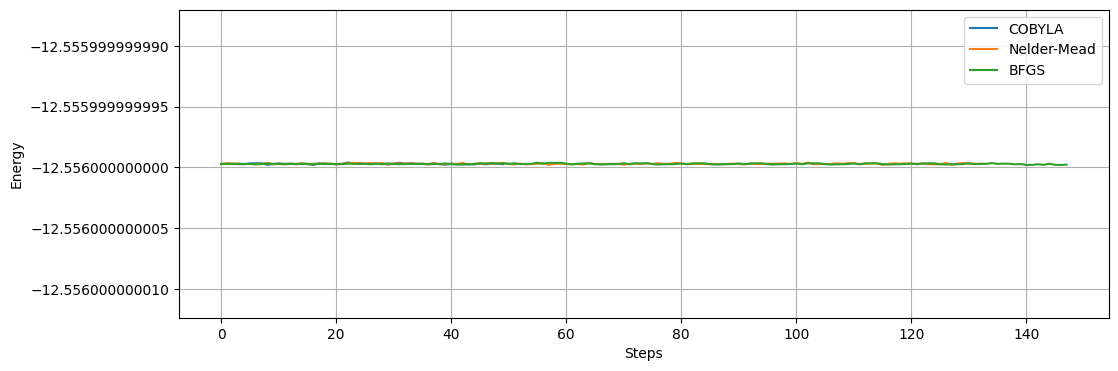

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter

ax = plt.gca()
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)

for method in methods:
    plt.plot(eval(result[method].meta_data['optimization_trace']),
             label=method)
plt.grid()
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy");

As seen above the plot we get the minimum energy directly from the first iterations. And we get the same value as in qiskit.

### Energy calculation using cirq
<hr>

First we need to change the circuit into type cirq instead of QLM type.

In [35]:
from qat.interop.cirq import qlm_to_cirq
cirq_circuit = qlm_to_cirq(qlm_circuit)
#print(cirq_circuit)

Cirq uses the concept of a sweep in which the values of the parameters are chosen randomly in each iteration instead of using an optimizer.

We now define 2 arrays for storing the energies and parameters.

In [36]:
import random
energies = []
random_params = []

Now we define the simulator in cirq.

In [37]:
import cirq

simulator = cirq.Simulator()

Now we define the observable

In [38]:
q1 = cirq.LineQubit(1)
q2 = cirq.LineQubit(2)
q3 = cirq.LineQubit(3)
q4 = cirq.LineQubit(4)
q5 = cirq.LineQubit(5)
q6 = cirq.LineQubit(6)

pauli_terms=[J1*cirq.X(q1)*cirq.X(q3), 
             J1*cirq.Y(q1)*cirq.Y(q3), 
             J1*cirq.Z(q1)*cirq.Z(q3), 
             J1*cirq.X(q1)*cirq.X(q2), 
             J1*cirq.Y(q1)*cirq.Y(q2), 
             J1*cirq.Z(q1)*cirq.Z(q2), 
             J1*cirq.X(q2)*cirq.X(q4), 
             J1*cirq.Y(q2)*cirq.Y(q4), 
             J1*cirq.Z(q2)*cirq.Z(q4), 
             J1*cirq.X(q3)*cirq.X(q5), 
             J1*cirq.Y(q3)*cirq.Y(q5), 
             J1*cirq.Z(q3)*cirq.Z(q5), 
             J1*cirq.X(q3)*cirq.X(q4), 
             J1*cirq.Y(q3)*cirq.Y(q4), 
             J1*cirq.Z(q3)*cirq.Z(q4), 
             J1*cirq.X(q4)*cirq.X(q6), 
             J1*cirq.Y(q4)*cirq.Y(q6), 
             J1*cirq.Z(q4)*cirq.Z(q6), 
             J1*cirq.X(q5)*cirq.X(q6), 
             J1*cirq.Y(q5)*cirq.Y(q6), 
             J1*cirq.Z(q5)*cirq.Z(q6), 
             J2*cirq.X(q1)*cirq.X(q4), 
             J2*cirq.Y(q1)*cirq.Y(q4), 
             J2*cirq.Z(q1)*cirq.Z(q4), 
             J2*cirq.Z(q1)*cirq.Z(q5), 
             J2*cirq.Y(q1)*cirq.Y(q5), 
             J2*cirq.Z(q1)*cirq.Z(q5), 
             J2*cirq.X(q1)*cirq.X(q6), 
             J2*cirq.Y(q1)*cirq.Y(q6), 
             J2*cirq.Z(q1)*cirq.Z(q6), 
             J2*cirq.X(q2)*cirq.X(q3), 
             J2*cirq.Y(q2)*cirq.Y(q3), 
             J2*cirq.Z(q2)*cirq.Z(q3), 
             J2*cirq.X(q2)*cirq.X(q5), 
             J2*cirq.Y(q2)*cirq.Y(q5), 
             J2*cirq.Z(q2)*cirq.Z(q5), 
             J2*cirq.X(q2)*cirq.X(q6), 
             J2*cirq.Y(q2)*cirq.Y(q6), 
             J2*cirq.Z(q2)*cirq.Z(q6), 
             J2*cirq.X(q3)*cirq.X(q6), 
             J2*cirq.Y(q3)*cirq.Y(q6), 
             J2*cirq.Z(q3)*cirq.Z(q6), 
             J2*cirq.X(q4)*cirq.X(q5), 
             J2*cirq.Y(q4)*cirq.Y(q5), 
             J2*cirq.Z(q4)*cirq.Z(q5)]


observable = sum(pauli_terms)

Now we perform 1000 iterations of sweep.

In [39]:
for i in range(1000):
    # Generate a list of 4 random values between -1 and 1
    x = [2 * random.random() - 1 for _ in range(4)]
    resolver = cirq.ParamResolver({'a0': x[0], 'a1': x[1], 'a2': x[2], 'a3': x[3]})
    resolved_circuit = cirq.resolve_parameters(cirq_circuit, resolver)

    ev_list = simulator.simulate_expectation_values(
        cirq.Circuit(resolved_circuit), observables=[observable], permit_terminal_measurements=True
    )
    energies.append(ev_list[0].real)
    random_params.append(x)

In [40]:
print("The minimum energy found is ", min(energies))

The minimum energy found is  -12.813003054857251


### Conclusion:
<hr>

We have successfully shown how to build QAOA from scratch for quantum chemistry focusing in this tutorial on the heisenberg spin lattice chain, and we clearly saw how very powerfull QAOA is.

Also, we can clearly see that we were able to find a good approximation for the ground state energy using 3 quantum programming languages. Exchange packages is very important and can be revolutionary due to the following reasons:
<ul>
    <li>We have the code written in one language but we need to use the features in another langauge, for example error correction features in qiskit, then we can change the circuit from cirq to qiskit for example.</li>
    <li>If the circuits needed to change are very big, we cannot do that manually, then myQLM library can automate this.</li>
    <li>If a research group has access to google quantum computer but his circuit is in qiskit, then myQLM can be used to change the circuit to cirq and run successfully on google quantum computer.</li>
</ul>

### References:
<hr>
<ol>
    <li>QLM VQE tutorial: <a href="https://notebooks.gesis.org/binder/jupyter/user/myqlm-myqlm-notebooks-fywdbybe/notebooks/tutorials/variational_algorithms/vqe_getting_started_random_spin.ipynb">link</a></li>
    <li>Pennylane intro to QAOA: <a href="https://pennylane.ai/qml/demos/tutorial_qaoa_intro">link</a></li>
    <li>Qiskit Operators: <a href="https://qiskit-org-web-resources.s3.us.cloud-object-storage.appdomain.cloud/documentation/stable/0.19/tutorials/circuits_advanced/2_operators_overview.html">link</a></li>
    <li>Qiskit VQE: <a href="https://qiskit-community.github.io/qiskit-algorithms/tutorials/03_vqe_simulation_with_noise.html">link</a></li>
    <li>Research gate QAOA: <a href="https://www.researchgate.net/publication/365507469/figure/fig3/AS:11431281098234337@1668788487246/QAOA-circuit-diagram.png">link</a></li>
    <li>Heisenberg Spin-1/2 chain: <a href="https://studenttheses.uu.nl/bitstream/handle/20.500.12932/29919/Thesis.pdf?sequence=2">link</a></li>
    <li>Pennylane how to construct and load hamiltonians: <a href="https://pennylane.ai/blog/2021/05/how-to-construct-and-load-hamiltonians-in-pennylane">link</a></li>
</ol>